In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [22]:
data = pd.read_csv("C:\\Users\\ASUS\\Desktop\\MY PROJECT\\TS_SALES\\merged_ts_data.csv")
data.drop(columns = ['type', 'locale', 'locale_name'], inplace = True)

In [23]:
# function to get data
all_category = list(data['family'].unique())
def get_data(data, store_nos, category):
    df = data[data['store_nbr'].isin(store_nos)]
    df = df[df['family'].isin(category)]
    df['date'] = pd.to_datetime(df['date']) 
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['time'] = range(len(df))
    df = df.reset_index()
    if "id" in df.columns:
        df = df.drop(columns = ['id', 'onpromotion','index'], axis = 1)
    return(df)


# Exploratory Data Analysis (Overall data)

In [24]:
data.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,city,cluster,oil_price,holiday_flag
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,13,NaN,1
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,13,NaN,1
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Quito,13,NaN,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Quito,13,NaN,1
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Quito,13,NaN,1


In [25]:
data.shape

(3000888, 11)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   int64  
 6   transactions  float64
 7   city          object 
 8   cluster       int64  
 9   oil_price     float64
 10  holiday_flag  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 251.8+ MB


In [27]:
data.describe()

,id,store_nbr,sales,onpromotion,transactions,cluster,oil_price,holiday_flag
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,2.755104e+06,3.000888e+06,2.072466e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00,1.694602e+03,8.481481e+00,6.792559e+01,8.695126e-02
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01,9.632810e+02,4.649735e+00,2.566633e+01,2.817637e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,1.000000e+00,2.619000e+01,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00,1.046000e+03,4.000000e+00,4.638000e+01,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00,1.393000e+03,8.500000e+00,5.333000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00,2.079000e+03,1.300000e+01,9.580000e+01,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02,8.359000e+03,1.700000e+01,1.106200e+02,1.000000e+00


In [28]:
data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'transactions', 'city', 'cluster', 'oil_price', 'holiday_flag'],
      dtype='object')

## Missing values - Detection and treatment

In [29]:
# MISSING VALUES
data.isna().sum()

## Key takeaway ##
# 1. No missing value in sales column
# 2. Missing values in transactions and oil price

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
transactions    245784
city                 0
cluster              0
oil_price       928422
holiday_flag         0
dtype: int64

In [33]:
# MISSING VALUE TREATMENT
'''
Not treating missng values right now, when we will extract time series from the 
data we will perform it everytime. because we are doing interpolation and current data 
structure will not support it.
'''


'\nNot treating missng values right now, when we will extract time series from the \ndata we will perform it everytime. because we are doing interpolation and current data \nstructure will not support it.\n'

In [34]:
print(data['date'].unique())
print(data['date'].nunique())
print(data.shape[0]/data['date'].nunique())

## Key takeaway ##
# 1. there are 1684 unique dates
# 2. each date is repeated 1782 times 

['2013-01-01' '2013-01-02' '2013-01-03' ... '2017-08-13' '2017-08-14'
 '2017-08-15']
1684
1782.0


In [35]:
len(data['family'].unique())

33

In [36]:
print(data['store_nbr'].unique())
print(data['store_nbr'].nunique())

print(data['store_nbr'].value_counts())
# number of unique dates
55572/33

## Key takeaway ##
# 1. there are 54 stores with each store having 55572 entries
# 2. for each date we have data of all 33 family items 

[ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]
54
1     55572
46    55572
36    55572
37    55572
38    55572
39    55572
4     55572
40    55572
41    55572
42    55572
43    55572
44    55572
45    55572
47    55572
10    55572
48    55572
49    55572
5     55572
50    55572
51    55572
52    55572
53    55572
54    55572
6     55572
7     55572
8     55572
35    55572
34    55572
33    55572
32    55572
11    55572
12    55572
13    55572
14    55572
15    55572
16    55572
17    55572
18    55572
19    55572
2     55572
20    55572
21    55572
22    55572
23    55572
24    55572
25    55572
26    55572
27    55572
28    55572
29    55572
3     55572
30    55572
31    55572
9     55572
Name: store_nbr, dtype: int64


1684.0

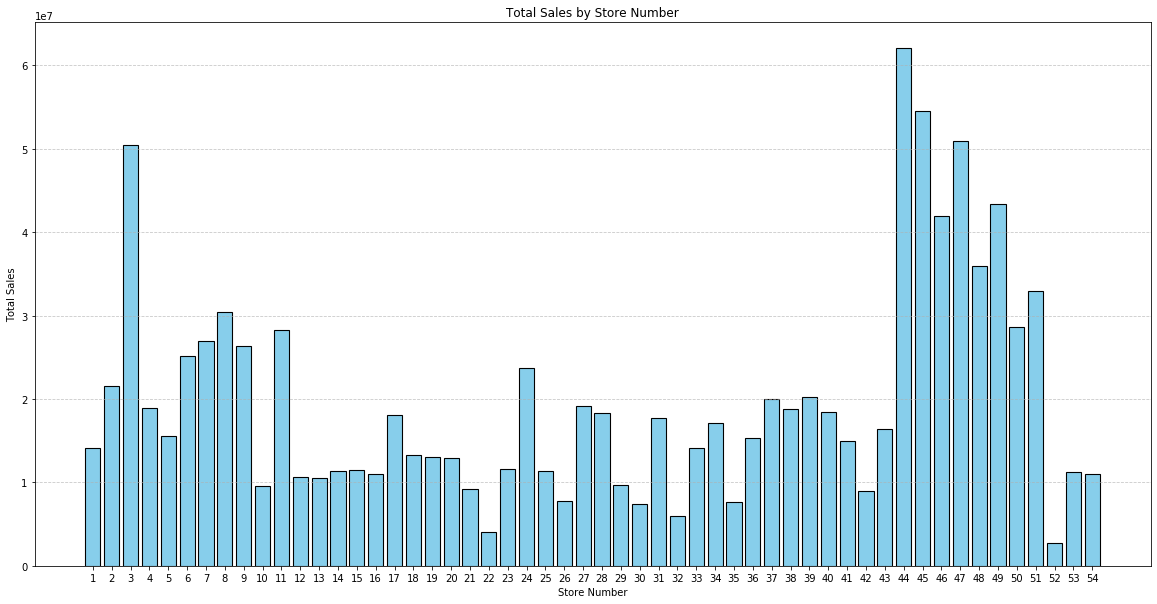

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your DataFrame
df = data.groupby('store_nbr').sum()
df1 = df.groupby('store_nbr')['sales'].sum()

# Reset index to get 'store_nbr' as a column again
df1 = df1.reset_index()

plt.figure(figsize=(20,10))
bars = plt.bar(df1['store_nbr'], df1['sales'], color='skyblue', edgecolor='black', linewidth=1.1)

plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.title('Total Sales by Store Number')

# Customize x-axis ticks for better readability
plt.xticks(df1['store_nbr'])

# Adding grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding a legend if needed
# plt.legend(['Total Sales'])

plt.savefig('C:\\Users\\ASUS\\Desktop\\total_sales_by_store.png')
plt.show()

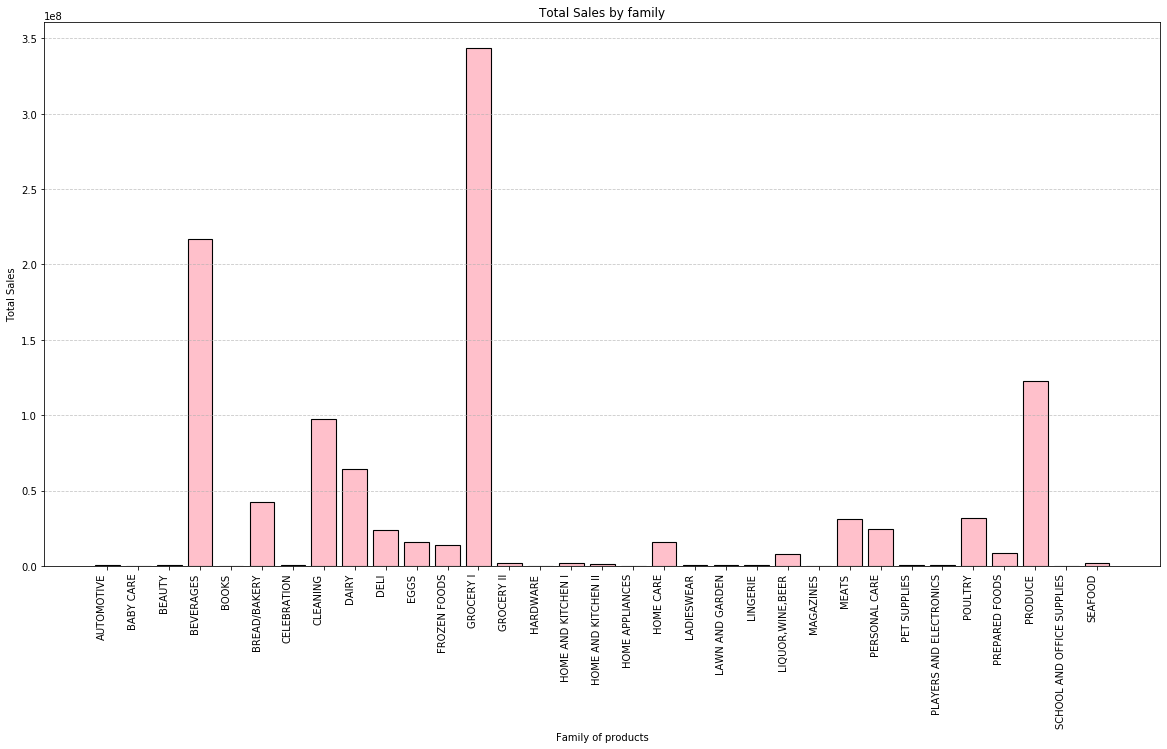

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your DataFrame
df = data.groupby('family').sum()
df1 = df.groupby('family')['sales'].sum()

# Reset index to get 'store_nbr' as a column again
df1 = df1.reset_index()

plt.figure(figsize=(20,10))
bars = plt.bar(df1['family'], df1['sales'], color='pink', edgecolor='black', linewidth=1.1)

plt.xlabel('Family of products')
plt.ylabel('Total Sales')
plt.title('Total Sales by family')

# Customize x-axis ticks for better readability
plt.xticks(df1['family'], rotation=90, ha='right')

# Adding grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding a legend if needed
# plt.legend(['Total Sales'])

plt.savefig('C:\\Users\\ASUS\\Desktop\\total_sales_by_category.png')
plt.show()

# Individual Time Series Analysis

In [121]:
df = get_data(data, [25], ['BEVERAGES'])
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

### EDA

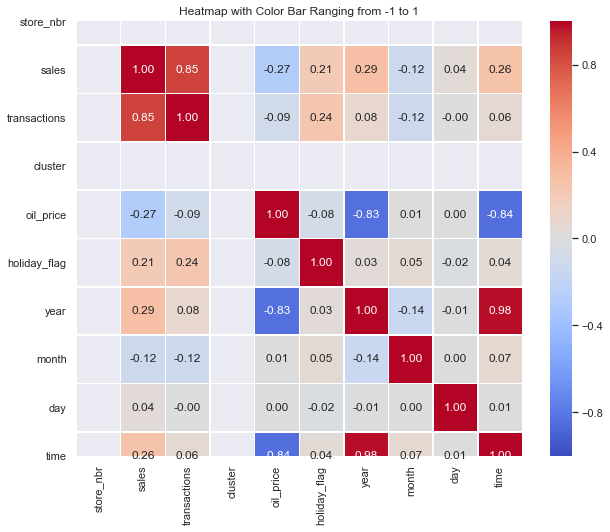

In [159]:
# heatmap
df1 = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df1, cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar_kws={"orientation": "vertical"})
plt.title('Heatmap with Color Bar Ranging from -1 to 1')
plt.show()

#### STEP 1 - Outlier detection

In [65]:
def handle_outliers(series):
    # Calculate the z-scores
    z_scores = (series - series.mean()) / series.std()

    # Identify and interpolate outliers
    outliers = (z_scores > 3) | (z_scores < -3)

    # Interpolate outliers using linear interpolation
    series[outliers] = np.interp(series.index[outliers], series.index[~outliers], series[~outliers])

    return series


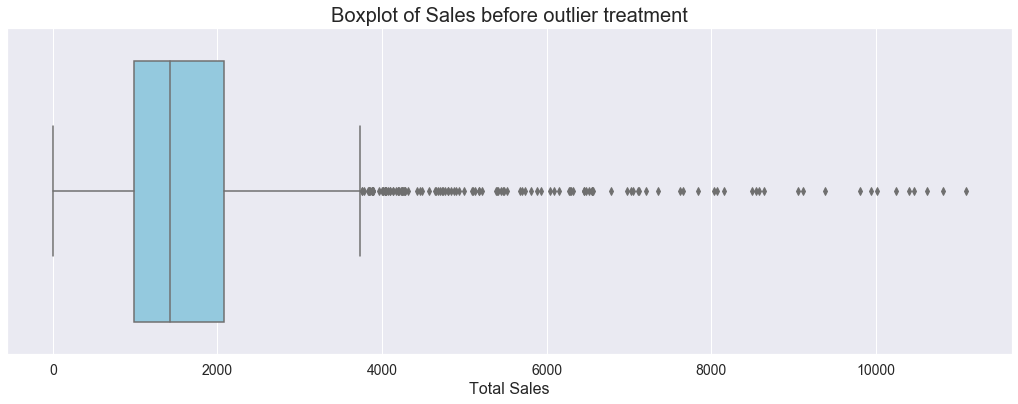

In [66]:
# Draw the boxplot
plt.figure(figsize = (18,6))
sns.boxplot(x="sales", data=df, color = "skyblue")

# Add labels and title with increased font size
plt.xlabel("Total Sales", fontsize=16)
plt.title("Boxplot of Sales before outlier treatment", fontsize=20)

# Increase the font size of x-axis ticks
plt.xticks(fontsize=14)
# Show the plot
plt.show()

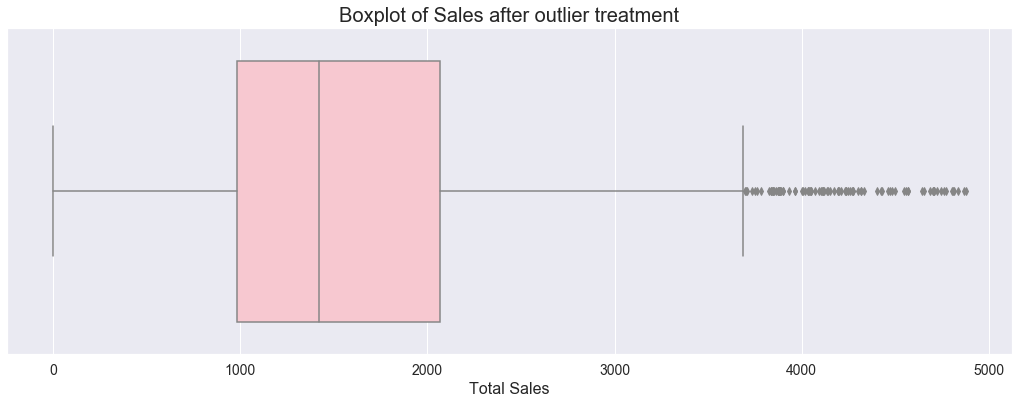

In [67]:
# Treatment
df = get_data(data = data, store_nos = [25], category = ['BEVERAGES'])
rem_out = handle_outliers(df['sales'])
# Draw the boxplot
plt.figure(figsize=(18, 6))
sns.boxplot(handle_outliers(df['sales']), color="pink")

# Add labels and title with increased font size
plt.xlabel("Total Sales", fontsize=16)
plt.title("Boxplot of Sales after outlier treatment", fontsize=20)

# Increase the font size of x-axis ticks
plt.xticks(fontsize=14)

# Show the plot
plt.show()


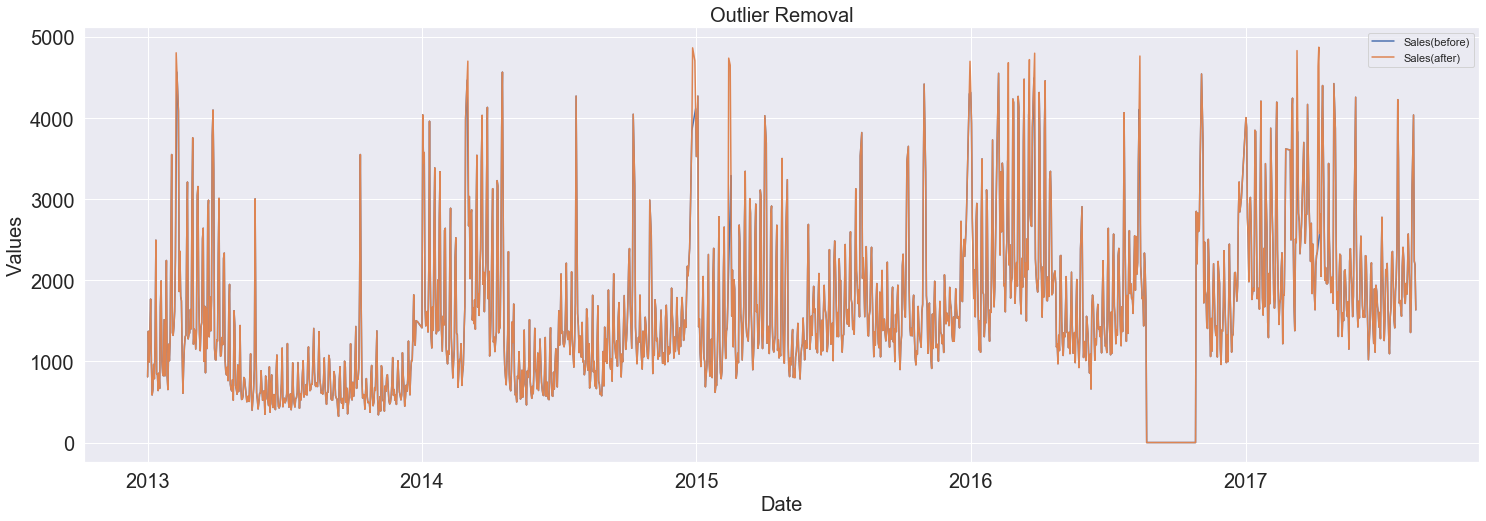

In [68]:
dat = pd.DataFrame()
dat['date'] = df['date']
dat['sales_a'] = df['sales']
dat['sales_b'] = handle_outliers(df['sales'])


# Set the style of the plot
sns.set(style="darkgrid")

# Create a line plot for Time Series 1
plt.figure(figsize=(25, 8))
sns.lineplot(x='date', y='sales_b', data=dat, label='Sales(before)')

# Create a line plot for Time Series 2
sns.lineplot(x='date', y='sales_a', data=dat, label='Sales(after)')

# Add labels and title with increased font size
plt.xlabel("Date", fontsize=20)
plt.ylabel("Values", fontsize=20)
plt.title("Outlier Removal", fontsize=20)

# Increase the font size of x-axis and y-axis ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show the legend
plt.legend()

# Show the plot
plt.show()

#### STEP 2 Missing value treatment

In [86]:
imputed_dataframe.isna().sum() 

date            0
store_nbr       0
family          0
sales           0
transactions    0
city            0
cluster         0
oil_price       0
holiday_flag    0
year            0
month           0
day             0
time            0
dtype: int64

In [87]:
import pandas as pd

def treat_missing_values(df, method='linear'):
    missing_val_col = df.columns[df.isna().sum() != 0]
    for i in missing_val_col:
        if method == 'ffill':
            df[i] = df[i].ffill()
        elif method == 'bfill':
            df[i] = df[i].bfill()
        elif method == 'linear':
            df[i] = df[i].interpolate(method='linear', inplace=False)
        else:
            raise ValueError("Invalid imputation method. Choose 'ffill', 'bfill', or 'linear'.")
    df = df.dropna()
    return df

df = treat_missing_values(df, method='linear')


#### STEP 3 - Testing for components of time series

In [93]:
'''
FUNCTIONS for stationarity testing

Case 1: Both tests conclude that the series is not stationary -> series is not stationary
Case 2: Both tests conclude that the series is stationary -> series is stationary
Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary
Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary
'''
# ADF
def ADF(vec):
    result = adfuller(vec)
    if(result[1]<0.05):
        ans = "STATIONARY"
    else:
        ans = "NON STATIONARY"
    return(ans)
    
# KPSS
def KPSS(vec):
    result = kpss(vec, regression='c')
    if(result[1]>0.05):
        ans = "STATIONARY"
    else:
        ans = "NON STATIONARY"
    return(ans)
ADF(df['sales'])
KPSS(df['sales'])

def stationarity_test(vec):
    adf = ADF(vec)
    kpss = KPSS(vec)
    if adf == 'NON STATIONARY' and kpss == 'NON STATIONARY':
        ans = 'NON STATIONARY'
    elif adf == 'STATIONARY' and kpss == 'STATIONARY':
        ans = 'STATIONARY'
    elif adf == 'NON STATIONARY' and kpss == 'STATIONARY':
        ans = 'TREND STATIONARY'
    elif adf == 'STATIONARY' and kpss == 'NON STATIONARY':
        ans = 'DIFFERENCE STATIONARY'
    return ans
    

In [94]:
stationarity_test(df['sales'])

'DIFFERENCE STATIONARY'

In [131]:
ts.diff()

date
2013-01-01       NaN
2013-01-02     563.0
2013-01-03    -381.0
2013-01-04     325.0
2013-01-05     453.0
               ...  
2017-08-11    3195.0
2017-08-12   -2277.0
2017-08-13   -1803.0
2017-08-14     -48.0
2017-08-15    -554.0
Name: sales, Length: 1684, dtype: float64

In [134]:
ts = df['sales']
differenced_ts = ts.diff()
differenced_ts = differenced_ts.dropna()
stationarity_test(differenced_ts)
# Made stationary by first order differencing

'STATIONARY'

In [114]:
# RELAIVE ORDERING TEST
import numpy as np
from scipy.stats import norm

def relative_ordering_test(time_series, significance_level=0.05):


    # Convert time_series to a NumPy array
    time_series = np.array(time_series)

    # Calculate the number of runs
    runs = np.sum(np.diff(time_series) != 0) + 1

    # Calculate the expected number of runs and variance of runs
    n1 = np.sum(time_series[:-1] < time_series[1:])
    n2 = len(time_series) - 1 - n1
    expected_runs = (2 * n1 * n2) / (n1 + n2) + 1
    variance_runs = (2 * n1 * n2 * (2 * n1 * n2 - n1 - n2)) / ((n1 + n2)**2 * (n1 + n2 - 1))

    # Calculate the test statistic
    z = (runs - expected_runs) / np.sqrt(variance_runs)

    # Compare the test statistic with the critical values
    critical_value = norm.ppf(1 - significance_level / 2)
    is_stationary = abs(z) <= critical_value

    # Return the result
    result = 'Stationary' if is_stationary else 'Non-Stationary'
    return result

test_result = relative_ordering_test(df['sales'])
print(f"The time series is {test_result} based on the Relative Ordering Test for trend stationarity.")


The time series is Non-Stationary based on the Relative Ordering Test for trend stationarity.


#### Step 4 Forecasting

###  Linear Regression

### Regression

Root Mean Squared Error on Test Set: 659.937876974991


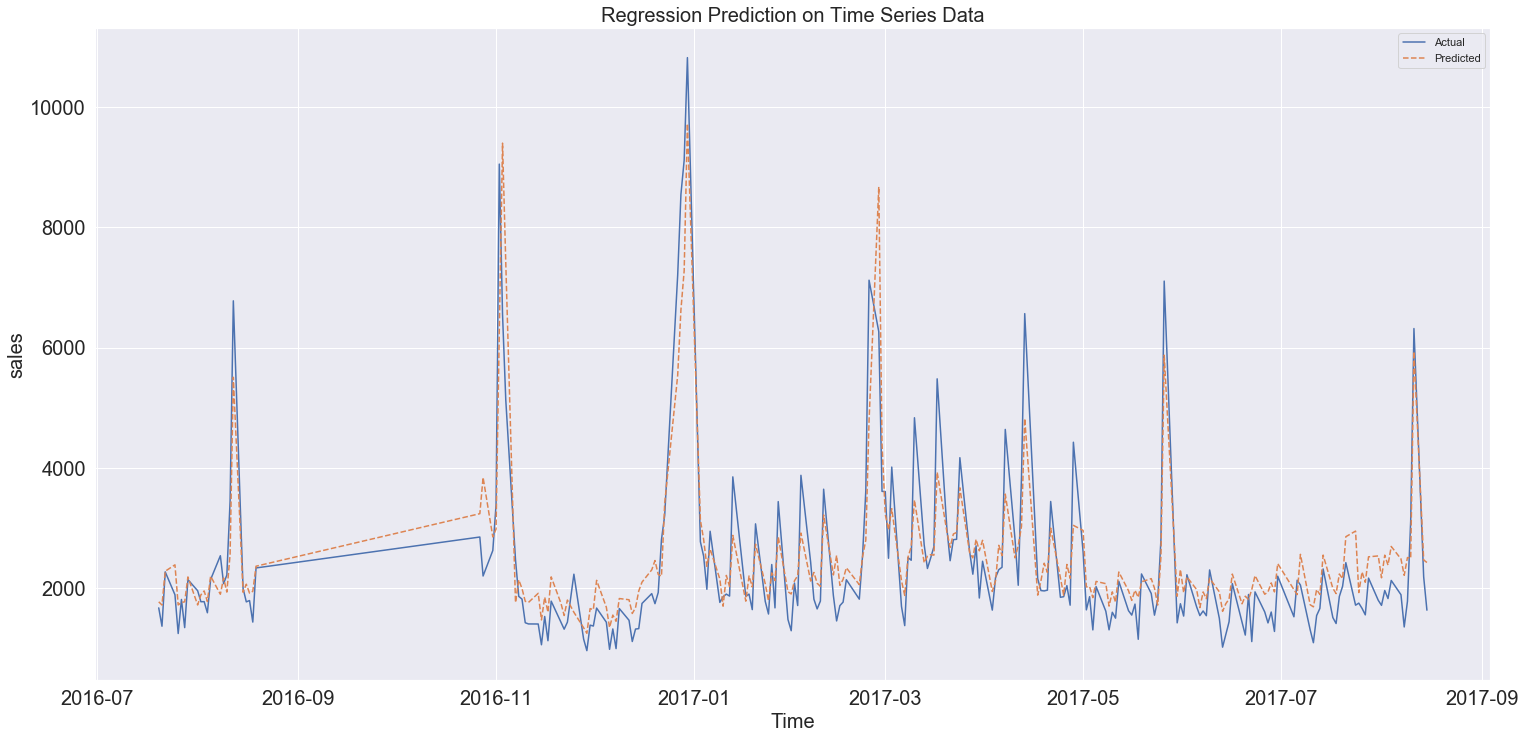

In [221]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def time_series_regression_prediction(time_series, target_column, window_size):
    """
    Perform regression prediction on time series data.

    Parameters:
    - time_series (pd.DataFrame): DataFrame containing the time series data.
    - target_column (str): Name of the target variable to be predicted.
    - window_size (int): Size of the window used for creating input features.

    Returns:
    - model (sklearn.linear_model.LinearRegression): Trained linear regression model.
    - predictions (pd.Series): Predictions for the target variable.
    """
    time_series = df[[i for i in time_series.columns if time_series[i].dtype != 'object']]
    # Create lag features based on the window size
    for i in range(1, window_size + 1):
        time_series[f'{target_column}_lag_{i}'] = time_series[target_column].shift(i)

    # Drop rows with NaN values created by lag features
    time_series = time_series.dropna()

    # Split the data into features (X) and target variable (y)
    X = time_series.drop(target_column, axis=1)
    y = time_series[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Initialize and train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Print the mean squared error on the test set
    rmse = (mean_squared_error(y_test, predictions))**(0.5)
    print(f"Root Mean Squared Error on Test Set: {rmse}")

    # Plot actual vs. predicted values
    plt.figure(figsize=(25, 12))
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, predictions, label='Predicted', linestyle='dashed')
    plt.title('Regression Prediction on Time Series Data',fontsize = 20)
    plt.xlabel('Time',fontsize = 20)
    plt.ylabel(target_column,fontsize = 20)
    plt.legend()
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.show()

    return model, pd.Series(predictions, index=y_test.index), rmse

trained_model, predictions, rmse = time_series_regression_prediction(df, target_column='sales', window_size=1)


In [ ]:
rmse_li = []
for i in range(40):
    rmse_li.append(time_series_regression_prediction(df, target_column='sales', window_size=i)[2])


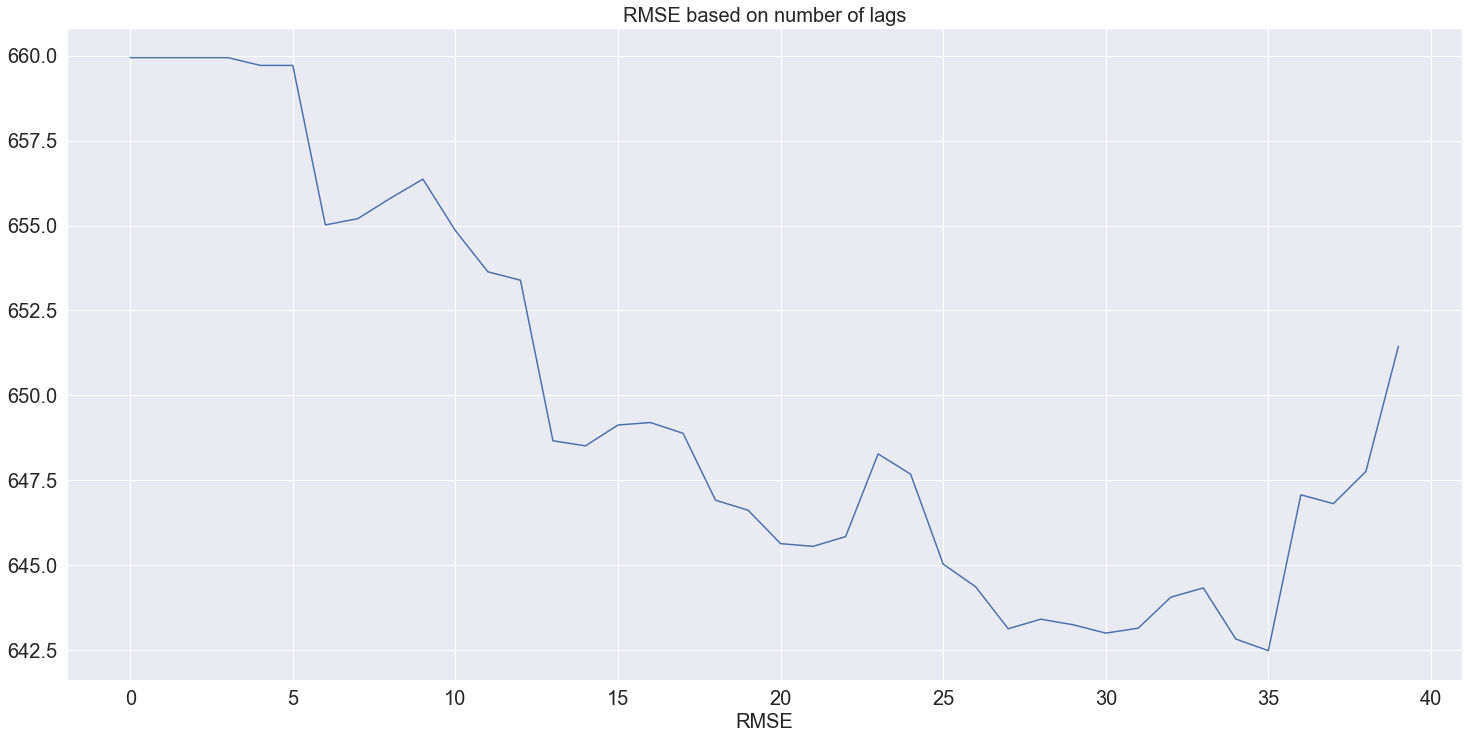

In [220]:
plt.figure(figsize=(25, 12))
plt.plot(range(40), rmse_li, label='Actual')
plt.title('RMSE based on number of lags', fontsize = 20)
plt.xlabel('Lags', fontsize = 20)
plt.xlabel('RMSE', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

Root Mean Squared Error on Test Set: 645.0406409962317


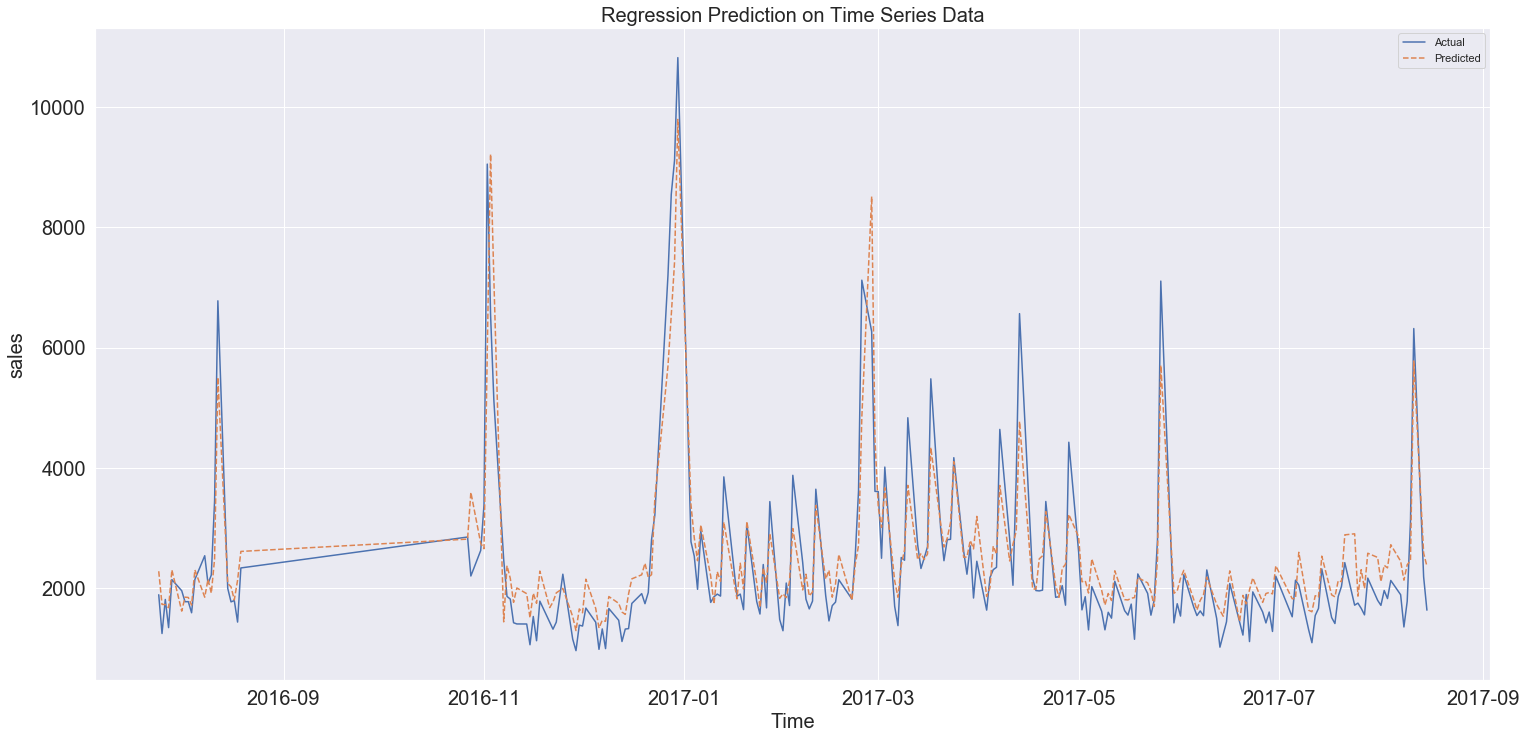

(LinearRegression(), date
 2016-07-25    2283.131171
 2016-07-26    1731.213498
 2016-07-27    1728.893668
 2016-07-28    1677.851340
 2016-07-29    2306.318450
                  ...     
 2017-08-09    2391.100098
 2017-08-10    2461.358142
 2017-08-11    5778.262803
 2017-08-14    2584.892896
 2017-08-15    2366.560483
 Length: 220, dtype: float64, 645.0406409962317)

In [222]:
# best one for lag 35
time_series_regression_prediction(df, target_column='sales', window_size=25)

### ARIMA

In [229]:
import statsmodels.graphics.tsaplots
import matplotlib.pyplot as plt

def acf_pacf(data):
    # Create a single figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 16))

    # Plot ACF
    acf = statsmodels.graphics.tsaplots.plot_acf(data['sales'], lags=100, title='Autocorrelation Function (ACF)', ax=ax1)

    # Plot PACF
    pacf = statsmodels.graphics.tsaplots.plot_pacf(data['sales'], lags=100, title='Partial Autocorrelation Function (PACF)', ax=ax2)
    plt.xticks(fontsize=20)
    # Show the plots
    plt.show()



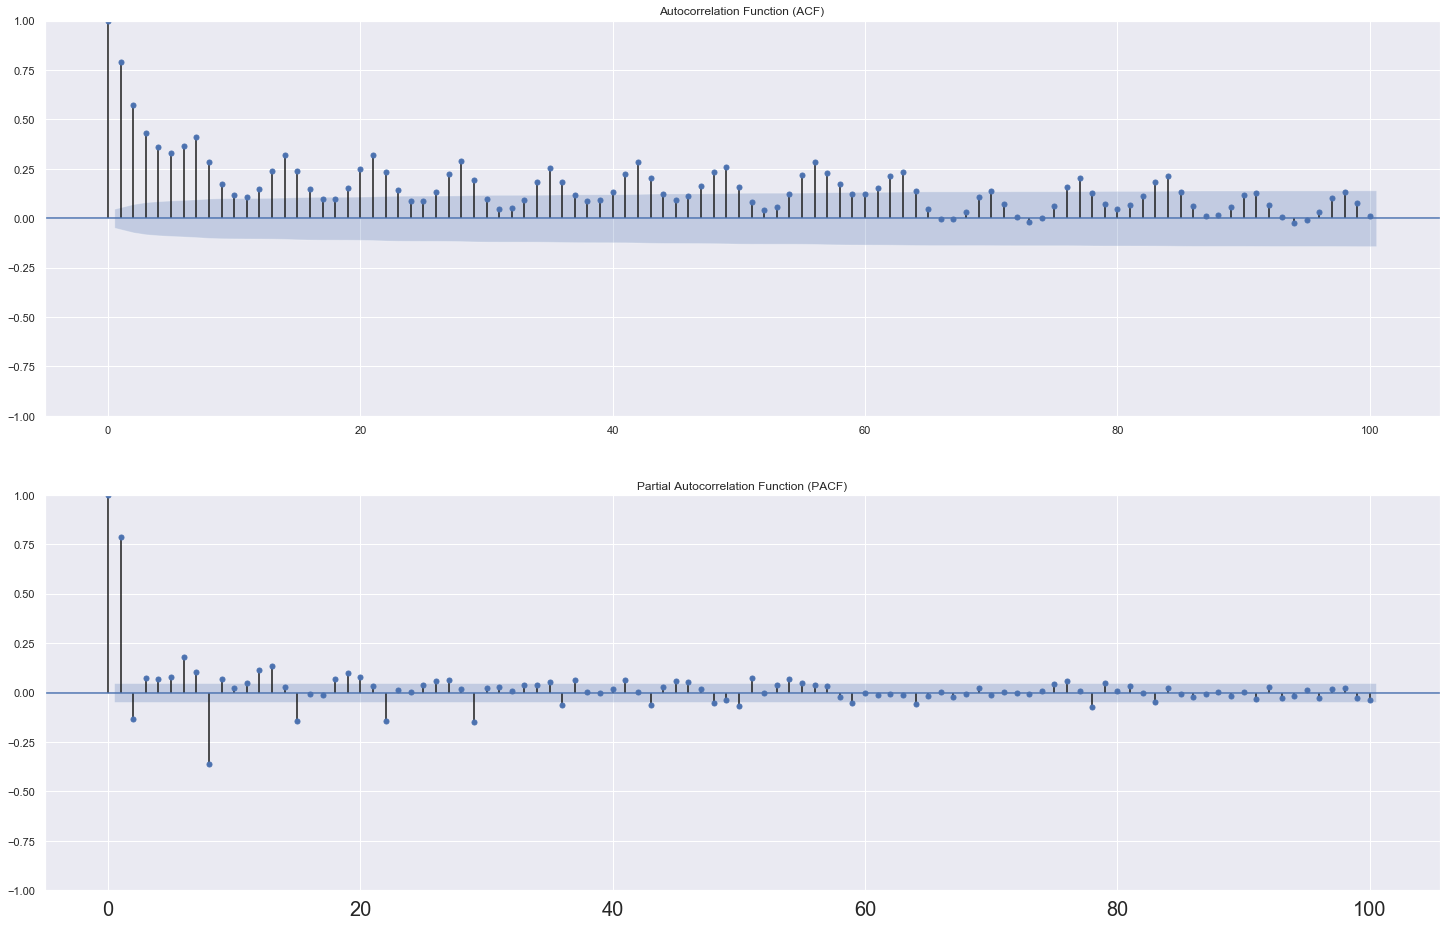

In [230]:
acf_pacf(df)

In [190]:
# Install the pmdarima library if you haven't already
# pip install pmdarima

import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

def forecast_arima(time_series, train_size=0.8):
    # Split the data into training and testing sets
    train, test = train_test_split(time_series, train_size=train_size)

    # Fit an ARIMA model using auto_arima
    model = pm.auto_arima(train,test = 'adf',stepwise = True, trace = True, suppress_warnings=True)

    # Make predictions
    predictions, conf_int = model.predict(n_periods=len(test), return_conf_int=True)
    test1 = list(dict(test).values())
    # Evaluate the model (optional)
    print("Mean Absolute Error:", np.mean(np.abs(predictions - test1)))
    print("Root Mean Squared Error:", np.sqrt(np.mean((predictions - test1) ** 2)))

    # Plot the results
    plt.figure(figsize = (25,10))
    plt.plot(np.arange(len(train)), train, label="Train")
    plt.plot(np.arange(len(train), len(train) + len(test)), test, label="Test")
    plt.plot(np.arange(len(train), len(train) + len(test)), predictions, label="Predictions")
    plt.fill_between(
        np.arange(len(train), len(train) + len(test)),
        conf_int[:, 0],
        conf_int[:, 1],
        color="k",
        alpha=0.1,
        label="Confidence Interval",
    )
    plt.legend()
    plt.show()
    

    return predictions,test, conf_int


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=27090.376, Time=1.00 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=28741.281, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=27122.476, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=27641.102, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30236.311, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=27092.993, Time=0.57 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=27097.500, Time=1.00 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=26894.140, Time=5.75 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=27089.830, Time=1.07 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=27025.785, Time=5.20 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=27051.036, Time=4.42 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=27069.862, Time=1.48 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=27083.786, Time=1.37 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=27018.041, Time=5.33 sec
 ARIMA(3,0,2)(0,0,0

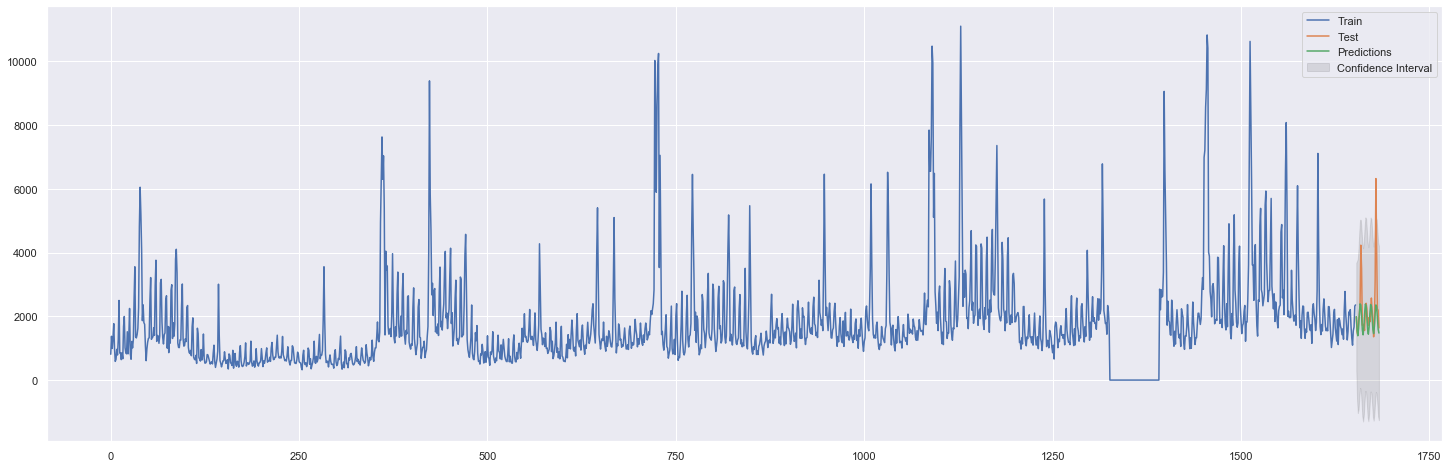

In [191]:
# prediction for next 34 days using ARIMA
model = forecast_arima(df['sales'], train_size=0.982)

### SARIMA

In [192]:

def forecast_sarima(time_series, train_size=0.8):
    # Split the data into training and testing sets
    train, test = train_test_split(time_series, train_size=train_size)

    # Fit an ARIMA model using auto_arima
    model = pm.auto_arima(train, seasonal=True,test = 'adf',stepwise = True, trace = True, suppress_warnings=True)

    # Make predictions
    predictions, conf_int = model.predict(n_periods=len(test), return_conf_int=True)
    test1 = list(dict(test).values())
    # Evaluate the model (optional)
    print("Mean Absolute Error:", np.mean(np.abs(predictions - test1)))
    print("Root Mean Squared Error:", np.sqrt(np.mean((predictions - test1) ** 2)))

    # Plot the results
    plt.figure(figsize = (25,8))
    plt.plot(np.arange(len(train)), train, label="Train")
    plt.plot(np.arange(len(train), len(train) + len(test)), test, label="Test")
    plt.plot(np.arange(len(train), len(train) + len(test)), predictions, label="Predictions")
    plt.fill_between(
        np.arange(len(train), len(train) + len(test)),
        conf_int[:, 0],
        conf_int[:, 1],
        color="k",
        alpha=0.1,
        label="Confidence Interval",
    )
    plt.legend()
    plt.show()

    return predictions, conf_int


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=27043.649, Time=1.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=28691.786, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=27075.701, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=27593.401, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30181.772, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=27046.258, Time=0.57 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=27050.828, Time=0.97 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=27040.345, Time=2.83 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=27043.107, Time=1.22 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=26979.222, Time=4.81 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=27037.081, Time=1.26 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=26981.978, Time=7.51 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=26973.664, Time=3.50 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=27001.117, Time=4.30 sec
 ARIMA(5,0,3)(0,0,0

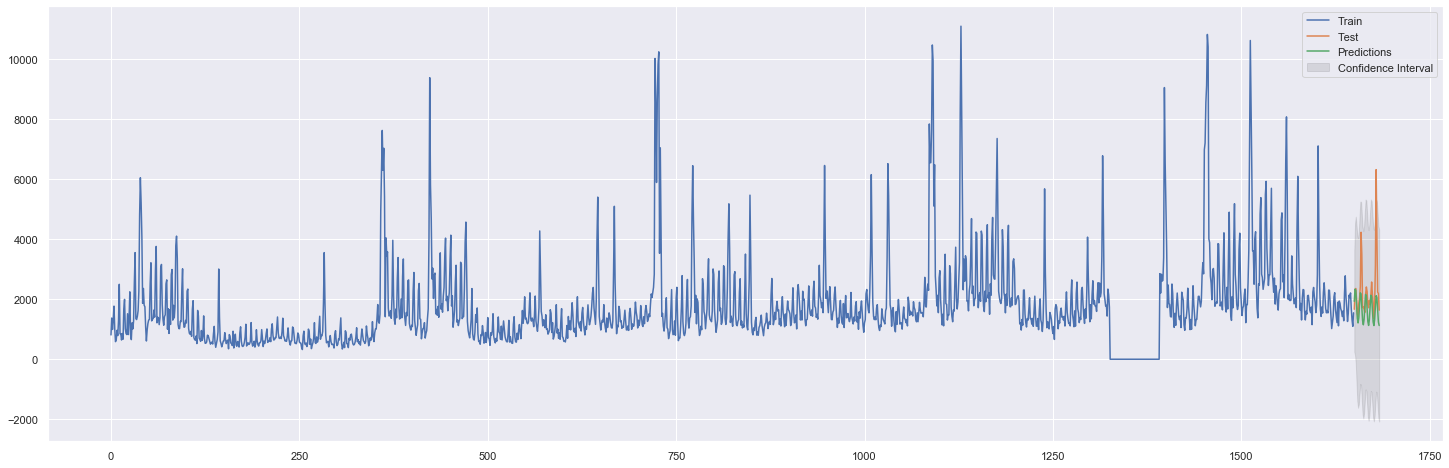

In [193]:
# prediction for next 34 days using ARIMA
model2 = forecast_sarima(df['sales'], train_size=0.98)